In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
df = pd.read_csv('data\\NBA_Player_Dataset-2013-2021.csv')

In [4]:
df.columns

Index(['Year', 'FULL NAME', 'TEAM', 'POS', 'AGE', 'GP', 'MPG', 'MIN%', 'USG%',
       'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG',
       'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'VI', 'ORTG', 'DRTG',
       'TO_100_Games', 'Salary', 'Cap Maximum', 'Salary%OfCap', 'Traded',
       'Center', 'Forward', 'Guard', 'Salary_Scaled', 'Salary_BoxCox',
       'Salary_Scaled_BoxCox'],
      dtype='object')

In [7]:
#remove unnecessary columns from correlation matrix
corr_df = df.drop(['Year', 'Salary', 'FULL NAME', 'TEAM', 'POS', 'Salary%OfCap', 'Traded', 'Cap Maximum', 'Salary', 'Salary_Scaled', 'Salary_BoxCox',
       'Salary_Scaled_BoxCox'], axis = 1)

#remove and add salary so it shows up at the bottom
corr_df['Salary'] = df['Salary']

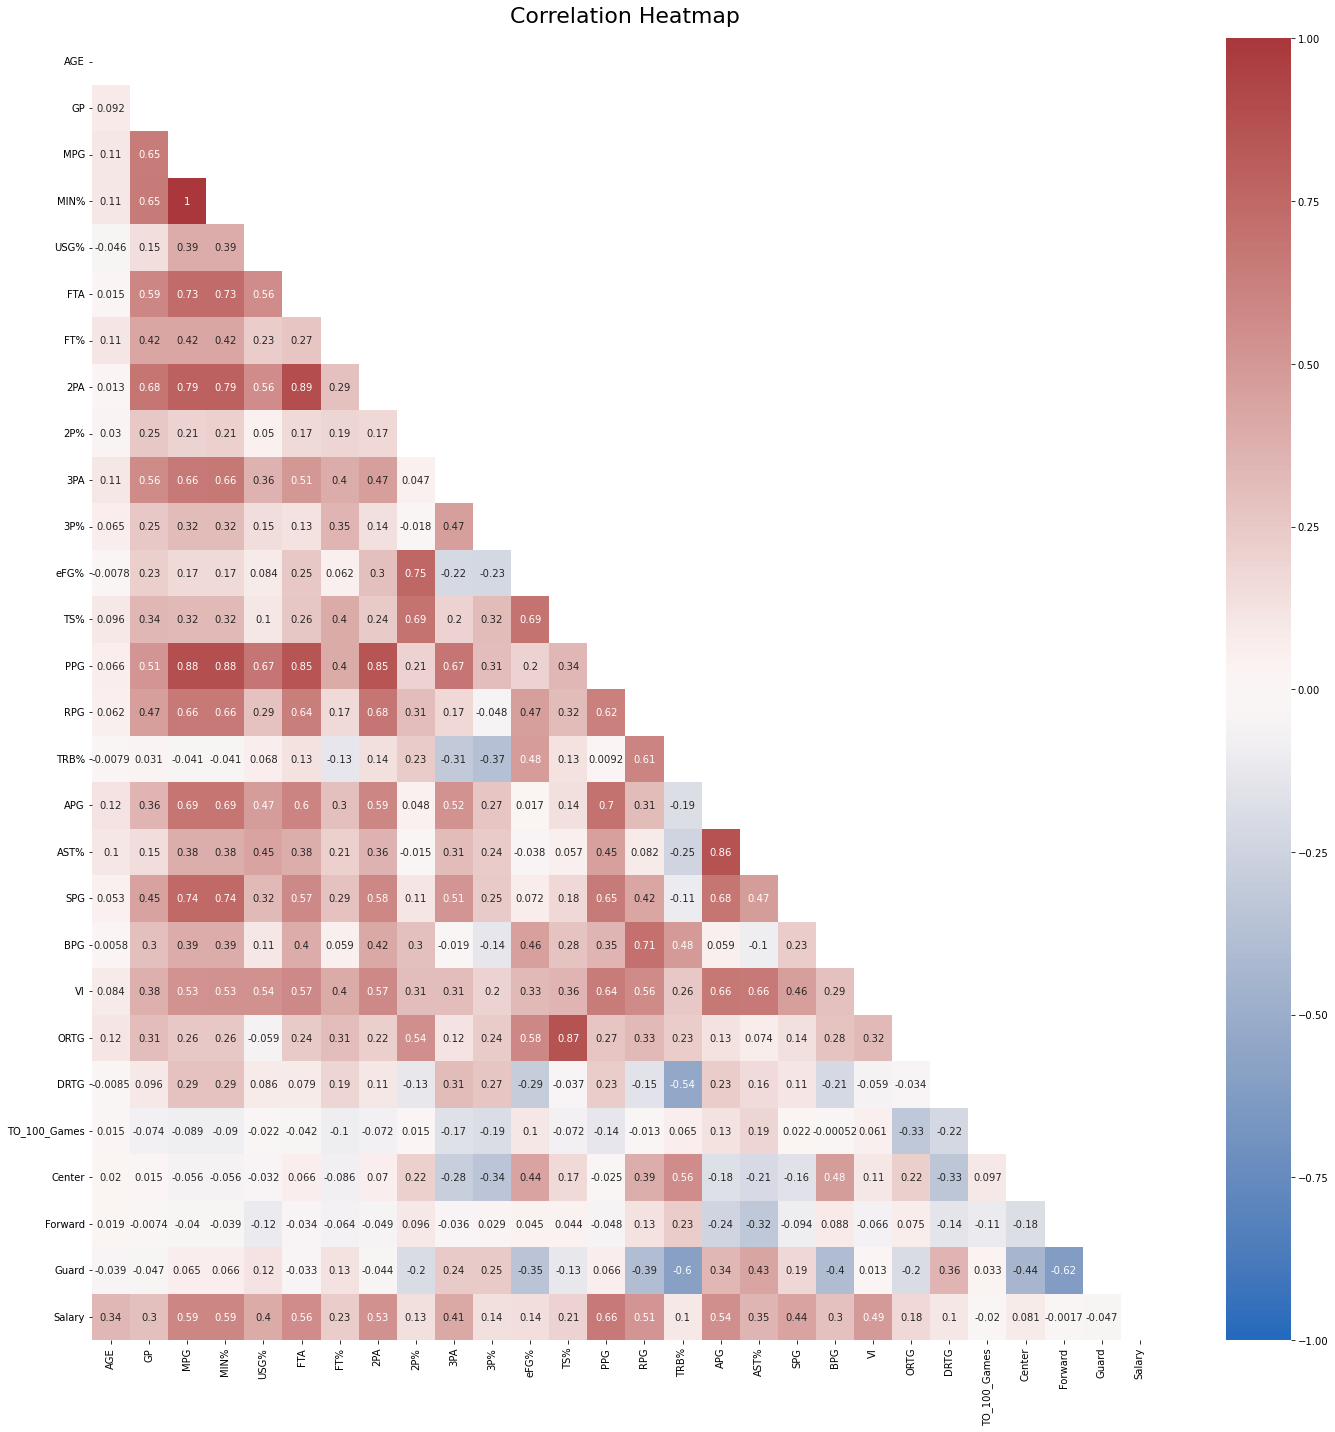

In [13]:
plt.figure(figsize=(20, 20))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr_df.corr(), dtype=bool))
heatmap = sns.heatmap(corr_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap = "vlag", annot_kws={"fontsize":10})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':22}, pad=16)

plt.tight_layout()
plt.savefig('images/correlation_heatmap.png')
plt.show()

# Correlation Discussion

Not that many highly correlated variables!  

In [6]:
threshold = 0.8

def high_cor_function(df):
    #correlation function to pull out highest values
    cor = df.corr()
    corrm = np.corrcoef(df.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]    
    thresh = threshold 
    print(high_cor[high_cor>thresh])



In [7]:
high_cor_function(corr_df)

max corr: nan , min corr:  nan
MIN%                  MPG                     0.999830
Salary_BoxCox         Salary_Scaled_BoxCox    0.985298
Salary_Scaled         Salary                  0.960549
FTA                   2PA                     0.885823
MIN%                  PPG                     0.881268
MPG                   PPG                     0.881209
Salary_Scaled_BoxCox  Salary_Scaled           0.871145
AST%                  APG                     0.856655
Salary_Scaled         Salary_BoxCox           0.856092
Salary_BoxCox         Salary                  0.853281
ORTG                  TS%                     0.850144
PPG                   2PA                     0.846227
                      FTA                     0.845875
Salary                Salary_Scaled_BoxCox    0.830750
dtype: float64


In [8]:
#Pull out the highest correlated features with target variable
threshold = 0.5

cor = corr_df.corr()

cor_criterion = abs(cor['Salary_BoxCox'])

relevant_features = cor_criterion[cor_criterion>threshold]
relevant_features = relevant_features.reset_index()
relevant_features.columns = ['Variables', 'Correlation']
relevant_features = relevant_features.sort_values(by='Correlation', ascending=False)
relevant_features

,Variables,Correlation
9,Salary_BoxCox,1.000000
10,Salary_Scaled_BoxCox,0.985298
8,Salary_Scaled,0.856092
11,Salary,0.853281
2,MIN%,0.666681
1,MPG,0.665768
5,PPG,0.651568
4,2PA,0.591465
3,FTA,0.565239
6,RPG,0.544103


# Explore Dependent Variable

Need to transform dependent variable, not normally distributed, most models make the assumption the dependent variable is normally distributed.

Box Cox works pretty good for this

<AxesSubplot:xlabel='Salary', ylabel='Count'>

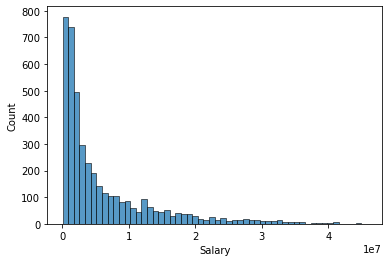

In [9]:
#histogram - salary is heavily skewed, lots of models make assumptions about the data being normally distributed.
#need to transform it.  

sns.histplot(df['Salary'])


In [10]:
df['Salary'].skew()

2.002903104031848

In [11]:
#boxcox transform the data, save parameter value

from scipy import stats

boxcox_y = stats.boxcox(df['Salary'])[0]
parameter = stats.boxcox(df['Salary'])[1]

In [12]:
df['Salary_BoxCox'] = boxcox_y

In [13]:
#much lower skew close to 0

pd.Series(boxcox_y).skew()

-0.04205960693140646

<AxesSubplot:ylabel='Count'>

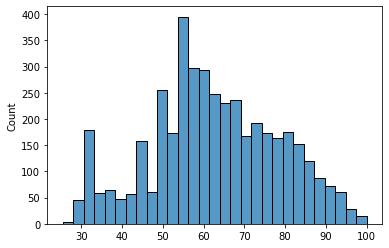

In [14]:
#histogram is "relatively" normal.  It's a lot better, should result in better predictive results

sns.histplot(boxcox_y)

In [15]:
#will need to invert the predicted values for any analysis, but it's easy.  

from scipy.special import inv_boxcox

inv_boxcox(boxcox_y, parameter)

array([ 2711280.        , 17073170.99999997, 28103500.00000001, ...,
        8599999.99999998,  3857040.        ,  1633440.        ])

In [16]:
df.columns

Index(['Year', 'FULL NAME', 'TEAM', 'POS', 'AGE', 'GP', 'MPG', 'MIN%', 'USG%',
       'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG',
       'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'VI', 'ORTG', 'DRTG',
       'TO_100_Games', 'Salary', 'Cap Maximum', 'Salary%OfCap', 'Traded',
       'Center', 'Forward', 'Guard', 'Salary_Scaled', 'Salary_BoxCox',
       'Salary_Scaled_BoxCox'],
      dtype='object')

<AxesSubplot:xlabel='Salary_Scaled', ylabel='Count'>

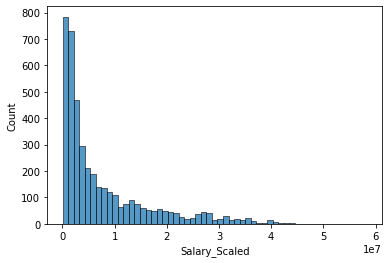

In [17]:
sns.histplot(df['Salary_Scaled'])

<AxesSubplot:xlabel='Salary_Scaled_BoxCox', ylabel='Count'>

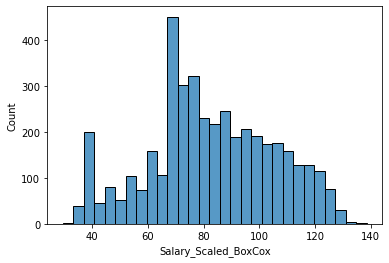

In [18]:
sns.histplot(df['Salary_Scaled_BoxCox'])

# Salary Changes over the years 

The violin plot shows the skewness of the data.  Was originally going to incorporate the salary cap to come up with some kind of adjusted salary based on the year, but after the box cox transformation...  Data looks okay.  Think we can just proceed.  

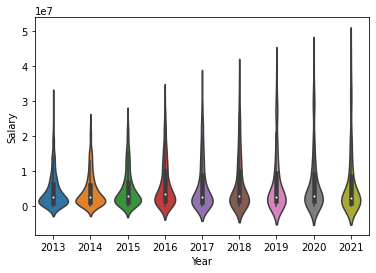

In [27]:
ax = sns.violinplot(x="Year", y="Salary", data=df)

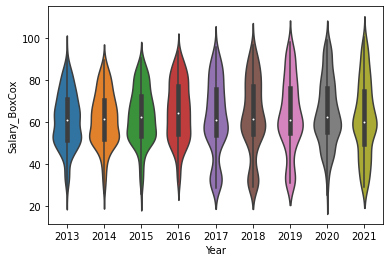

In [56]:
ax = sns.violinplot(x="Year", y="Salary_BoxCox", data=df)

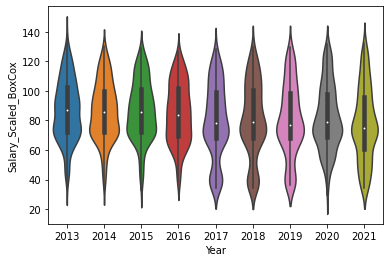

In [19]:
ax = sns.violinplot(x="Year", y="Salary_Scaled_BoxCox", data=df)

# Regression Plots

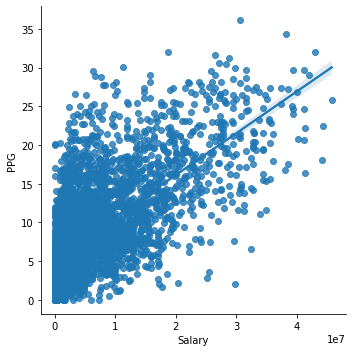

In [5]:
sns.lmplot(x='Salary',y='PPG',data=df)

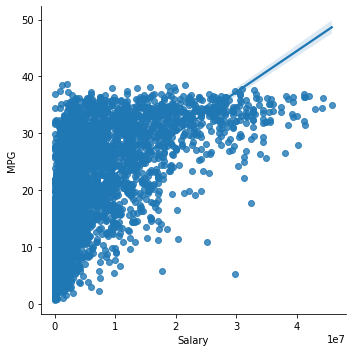

In [6]:
sns.lmplot(x='Salary',y='MPG',data=df)

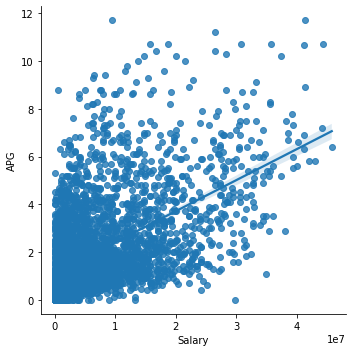

In [7]:
sns.lmplot(x='Salary',y='APG',data=df)